<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**


---

# Wine demand prediction

Wine is, without a doubt, one of the most popular alcoholic beverages in the world. Although scientists are still unsure about the benefits of wine, the idea that having "one glass of wine a day" can help prevent heart attacks is somewhat widespread in society<sup><a href="https://www.mayoclinic.org/diseases-conditions/heart-disease/in-depth/red-wine/art-20048281">1</a></sup>. Moreover, the wine industry was one of the many things the COVID-19 pandemic had an impact on, with wine sales (especially online) spiking over 500% at the peak period of lockdown in April 2020<sup><a href="https://www.forbes.com/sites/joemicallef/2021/06/22/how-post-pandemic-wine-consumption-trends-are-shaping--demand/">2</a></sup>. Without such an atypical reason for this rise sales, specialized wine stores might be able to predict their sales demand given that they have enough data on their sales over time.

<p align=center>
<img src="img/wine.jpg" width="40%"><br>
<i><sup>Image credits: wavebreakmedia-micro @ <a href="https://www.freepik.com/free-photo/glass-red-wine-bottle-bar-counter_8405671.htm">freepik</a>.</sup></i>
</p>

Such a representation of data is called a Time Series, and reflects a specific sequence of values measured along successive evenly spaced time points<sup><a href="https://en.wikipedia.org/wiki/Time_series">3</a></sup>. Predictions on Time Series — called **Time Series Forecasting** — is a form of *extrapolating* values in the future by leveraging previous data of interest and requires a specific methodology.

In this notebook, we will be predicting wine sales demand using [Facebook's Prophet](https://facebook.github.io/prophet/). Similar to PyCaret, Prophet is a low-code library that provides a strategy for working with time series forecasting based on an additive model that even takes into consideration holiday effects. It is also robust to missing data points and trend shifts, as well as able to handle outliers<sup><a href="https://facebook.github.io/prophet/">4</a></sup>.


## Demand forecasting and why it is important

**Demand forecasting** is, essentially, predicting the demand for products/materials that meet the company's needs, allowing for the maintenance of an optimal profit margin. It is constructed upon studying patterns in market dynamics, cause-effect relationships and trends of sales. And because changes constantly affect businesses, demand prediction becomes important from them<sup><a href="https://startup.info/why-demand-forecasting-is-important/">5</a></sup>.

Several factors can determine demand<sup><a href="https://byjus.com/commerce/demand/">6</sup></a>, such as the product costs, the consumers' incomes, the cost of related goods and services, consumer expectations well as the number of buyers in the market. All of these can be taken into account when trying to understand a particular product's demand.

On the other hand, **demand planning** is the process in which the business prepares itself for the *foreseeable* future, based on the forecast being made. With this, companies are able to stimulate consumer demand while also allowing the company to effectively meet the growing demand<sup><a href="https://startup.info/why-demand-forecasting-is-important/">5</a></sup>.

There are several benefits to be gained from time-series forecasting:

* **Price setting:** Predicting product popularity (or a lack thereof) allows for price adjustment (and setting up sales) which can have a great impact on revenue.
* **Budget:** Forecasting demand allows you to estimate the company budget, enabling you to reduce risk and make financial decisions, such as reallocating resources.
* **Improved supply infrastructure**: Knowing the business' demands allows for better control of inventory, of personnel needed.
* **Reducing uncertainty**: Uncertainty makes decision-making much more difficult, and knowing what to expect can reduce this impact and allow better planning.

Now that we have discussed this, let's dive in.

# The Data

The dataset used in the project today was a synthetic dataset created by Rafael at [Sigmoidal](https://sigmoidal.ai). It consists of a dataset from Kaggle which was modified to have 3 years of daily sales, distributed by 3 stores and 219 different products (modified from 5 years of daily sales, from 10 stores and 50 products). 

The products, though, are real and based on a real e-commerce offer of wines. Names, crops and prices are 100% real (in BRL and converted to USD). Some of the products might have appeared in the real market after a given start in sales for that product (for example, a wine from a 2015 crop started being sold in 2013, which makes no sense), but this is just the artifact of this artificial dataset. This might also be reflected in other unexpected characteristics like the trend in sales for a wine that is not very popular, for example.

From the products sheet, we will have the following variables:

* **item_id** = Item identification number.
* **name** = Name of the Wine.
* **producer** = Name of the Wine producer.
* **country** = Country of origin.
* **vintage** = The wine's vintage/harvest.
* **kind** = The type of wine.
* **price_brl** = Price in Brazilian Reais.
* **price_usd** = Price in US dollars.

While from the sales data we will have:

* **date** = The date of sale.
* **store** = The store that sold the item.
* **item** = The item that was sold.
* **sales** = The number of said items that were sold.

So, let's import our packages and prepare our data.

In [40]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
from prophet import Prophet


# Getting the data
df_prod = pd.read_csv("data/products.csv")
df_sale = pd.read_csv("data/sales-clean.csv")

# The Moon also rises
np.random.seed(6327)

# Defining plot parameters
# plt.style.use('dark_background')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.stretch'] = 'normal'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.variant'] = 'normal'
plt.style.use('ggplot')

In [41]:
# Seeing first entries of products dataset
df_prod.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


In [42]:
# Seeing first entries of sales dataset
df_sale.head()

,date,store,item,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10


### Preparing the data

One of the first things that we see is that the prices have commas (,) in the numbers, which should not be present in numerical data. Let's go ahead and check all our data variables.

In [43]:
# Checking columns from data
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    219 non-null    int64 
 1   name       219 non-null    object
 2   producer   219 non-null    object
 3   country    219 non-null    object
 4   region     219 non-null    object
 5   vintage    219 non-null    object
 6   kind       219 non-null    object
 7   price_brl  219 non-null    object
 8   price_usd  219 non-null    object
dtypes: int64(1), object(8)
memory usage: 15.5+ KB


Both price columns seem to have text instead of numbers, while the IDs of the items are set as numbers, so we go ahead and fix that. The vintage column also contains text ("NV" entry) which we will change to 0 to keep the column numeric.

In [44]:
# Fixing numbers (removing ,)
df_prod.replace(',', '', regex=True, inplace=True)

# Fixing types
df_prod.item_id = df_prod.item_id.astype(str)
df_prod.price_brl = pd.to_numeric(df_prod.price_brl)
df_prod.price_usd = pd.to_numeric(df_prod.price_usd)



In [45]:
# Fixing vintage column
df_prod.vintage.replace('NV', '0', inplace=True)
df_prod.vintage = pd.to_numeric(df_prod.vintage)

In [46]:
# Checking
df_prod.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,0,rose sparkling,489.0,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.0,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.4,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.0,267.82


In [47]:
# Checking types
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    219 non-null    object 
 1   name       219 non-null    object 
 2   producer   219 non-null    object 
 3   country    219 non-null    object 
 4   region     219 non-null    object 
 5   vintage    219 non-null    int64  
 6   kind       219 non-null    object 
 7   price_brl  219 non-null    float64
 8   price_usd  219 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 15.5+ KB


### Getting to know our dataset

But what about the products we are studying? Let's see what are the main features of our data.

In [48]:
# Printing info
print('Number of types of wine: ', len(df_prod.name.unique()))
print('Number of different producers: ', len(df_prod.producer.unique()))
print('Number of different countries: ', len(df_prod.country.unique()))
print('Number of different regions: ', len(df_prod.region.unique()))
print('Number of different types: ', len(df_prod.kind.unique()))
print('Number of vintages:', len(df_prod.vintage.unique()))
print('Price range (BRL):', min(df_prod.price_brl), '—', max(df_prod.price_brl))
print('Price range (USD):', min(df_prod.price_usd), '—', max(df_prod.price_usd))


Number of types of wine:  188
Number of different producers:  58
Number of different countries:  6
Number of different regions:  21
Number of different types:  5
Number of vintages: 17
Price range (BRL): 52.8 — 10992.0
Price range (USD): 9.13 — 1901.73


Even though this dataset was adapted to a smaller size, we can still see that we have a good range of products spanning a good price range as well. Diversity of price and options are essential for maintaining the sales and reaching every niche of wine enthusiasts. We can see that our dataset spans a wide range of producers, countries, regions and vintages, showing that the catalog can appeal to many audiences.


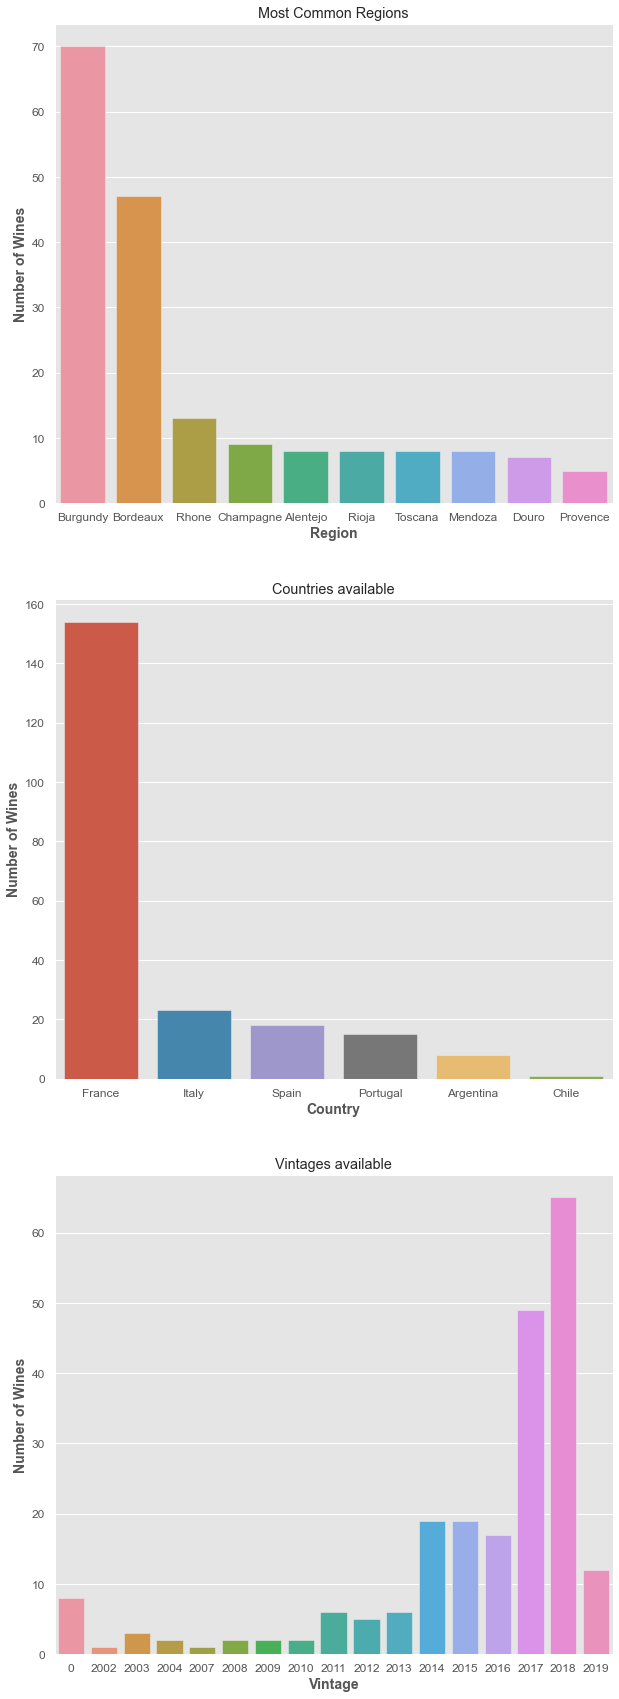

In [111]:
fig, ax = plt.subplots(3, 1, figsize=(10,30))

# Regions
sns.countplot(x=df_prod.region, order=df_prod.region.value_counts().index[0:10], ax=ax[0]).set(title='Most Common Regions')
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Number of Wines', fontsize=14, weight='bold')
ax[0].set_xlabel('Region', fontsize=14, weight='bold')

# Countries
sns.countplot(x=df_prod.country, order=df_prod.country.value_counts().index, ax=ax[1]).set(title='Countries available')
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Number of Wines', fontsize=14, weight='bold')
ax[1].set_xlabel('Country', fontsize=14, weight='bold')

# Vintages
sns.countplot(x=df_prod.vintage, ax=ax[2]).set(title='Vintages available')
ax[2].tick_params(axis='both', labelsize=12)
ax[2].set_ylabel('Number of Wines', fontsize=14, weight='bold')
ax[2].set_xlabel('Vintage', fontsize=14, weight='bold')

plt.show()

As one would imagine, we have variation in the price due to region of origin as well as the vintage of the wine:

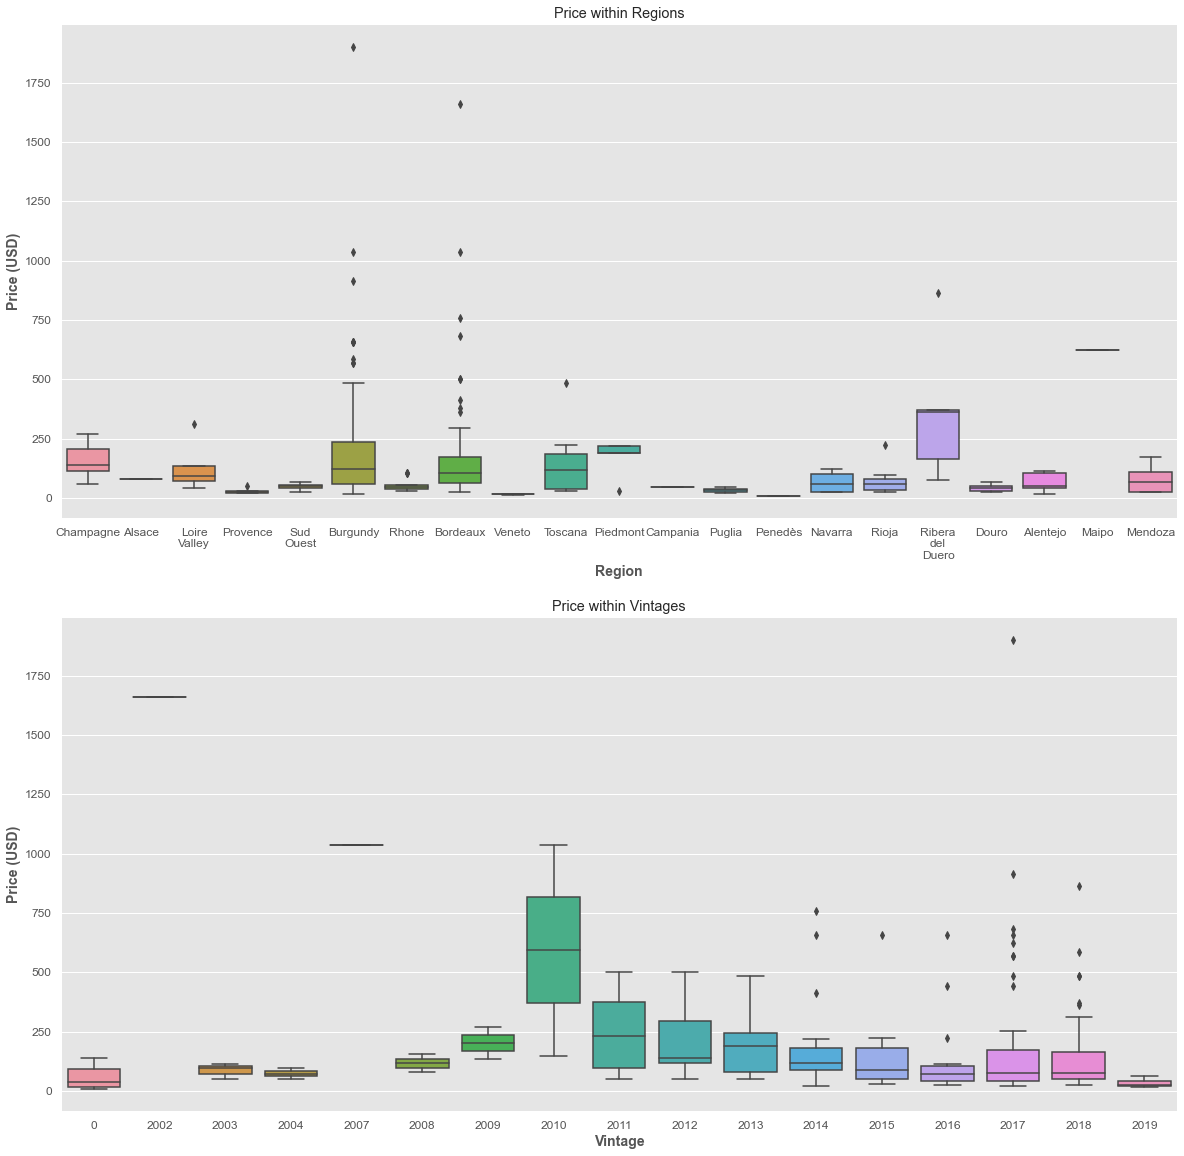

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(20,20))

# Regions
sns.boxplot(x=df_prod.region, y=df_prod.price_usd, ax=ax[0]).set(title='Price within Regions')
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[0].set_xlabel('Region', fontsize=14, weight='bold')
wrap_labels(ax[0], 3)

# Countries
sns.boxplot(x=df_prod.vintage, y=df_prod.price_usd).set(title='Price within Vintages')
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[1].set_xlabel('Vintage', fontsize=14, weight='bold')

plt.show()

From this, we can see that *Ribera del Duero* has a higher median price of wines, but both *Burdungy* and *Bordeaux* have the highest and second highest prices in our catalog. In addition, *2010 Vintages* have the highest median price, with the actual highest price being a *2017 Vintage*.

Let's see which are the most expensive and the cheapest wines available in our data.

In [49]:
# First, defining some code to wrap labels (Code by: Ted Petrou @ Dunder Data)
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

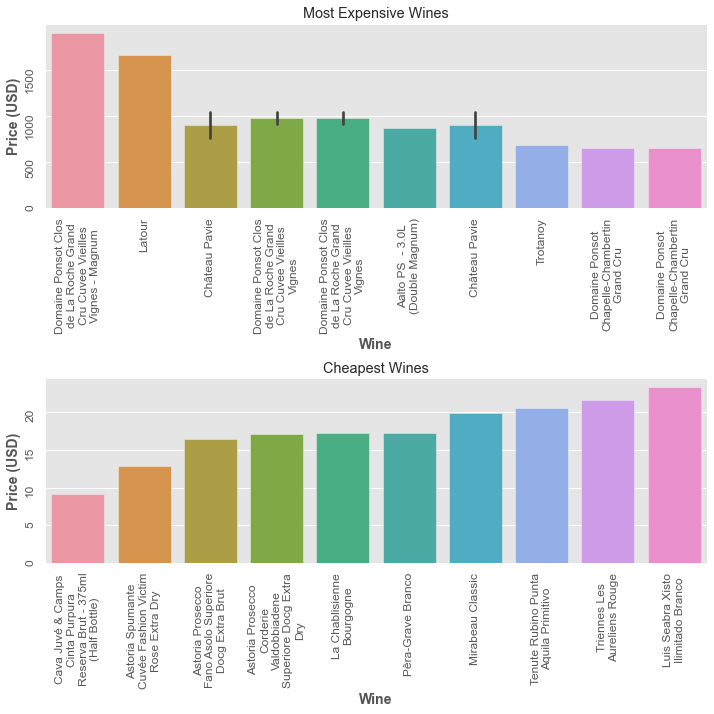

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# Most expensive wines
sns.barplot(x=df_prod.name, y=df_prod.price_usd, 
            order=df_prod.sort_values('price_usd', ascending=False).name.iloc[0:10], 
            ax=ax[0]).set(title='Most Expensive Wines')
wrap_labels(ax[0], 20)
ax[0].tick_params(rotation=90)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[0].set_xlabel('Wine', fontsize=14, weight='bold')

# Cheapest wines
sns.barplot(x=df_prod.name, y=df_prod.price_usd, 
            order=df_prod.sort_values('price_usd', ascending=True).name.iloc[0:10], 
            ax=ax[1]).set(title='Cheapest Wines')
wrap_labels(ax[1], 20)
ax[1].tick_params(rotation=90)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[1].set_xlabel('Wine', fontsize=14, weight='bold')

fig.tight_layout(pad=1)
plt.show()

In [65]:
# Cheapest and Most expensive wines
print('The cheapest wine in the catalog is:\n',
      df_prod.sort_values('price_usd', ascending=True).name.iloc[0],
      '\n Price: $' ,
      df_prod.sort_values('price_usd', ascending=True).price_usd.iloc[0],
      '\n')

print('The most expensive wine in the catalog is:\n',
      df_prod.sort_values('price_usd', ascending=False).name.iloc[0], 
      '\n Price: $' ,
      df_prod.sort_values('price_usd', ascending=False).price_usd.iloc[0], 
      '\n')

print('The mean price of wine in the store is:\n $',
      round(df_prod.price_usd.mean(), 2))

The cheapest wine in the catalog is:
 Cava Juvé & Camps Cinta Purpura Reserva Brut - 375ml (Half Bottle) 
 Price: $ 9.13 

The most expensive wine in the catalog is:
 Domaine Ponsot Clos de La Roche Grand Cru Cuvee Vieilles Vignes - Magnum 
 Price: $ 1901.73 

The mean price of wine in the store is:
 $ 167.41


## References

1: https://www.mayoclinic.org/diseases-conditions/heart-disease/in-depth/red-wine/art-20048281

2: https://www.forbes.com/sites/joemicallef/2021/06/22/how-post-pandemic-wine-consumption-trends-are-shaping--demand/?sh=6fa845857fe9

3: https://en.wikipedia.org/wiki/Time_series

4: https://facebook.github.io/prophet/

5: https://startup.info/why-demand-forecasting-is-important/